In [1]:
import numpy as np
from gait_modulation import FeatureExtractor2
from gait_modulation.utils.utils import *
import matplotlib.pyplot as plt

In [2]:
# Load the preprocessed data
patient_epochs = load_pkl('results/pickles/patients_epochs.pickle')
subjects_event_idx_dict = load_pkl('results/pickles/subjects_event_idx_dict.pickle')
sfreq = patient_epochs['PW_EM59'].info['sfreq']

In [3]:
# configuration for feature extraction
features_config = {
    'time_features': {
        # 'mean': True,
        # 'std': True,
        # 'median': True,
        # 'skew': True,
        # 'kurtosis': True,
        # 'rms': True
            # peak_to_peak = np.ptp(lfp_data, axis=2)
    },
    'freq_features': {
        'psd_raw': True,
            # psd_vals = np.abs(np.fft.rfft(lfp_data, axis=2))
        # 'psd_band_mean': True, band power!
        # 'psd_band_std': True,
        # 'spectral_entropy': True
    },
    # 'wavelet_features': {
    #     'energy': False
    # },
    # 'nonlinear_features': {
    #     'sample_entropy': True,
    #     'hurst_exponent': False
    # }
}


# Initialize the FeatureExtractor
feature_extractor = FeatureExtractor2(sfreq, features_config)

feature_handling = "flatten_chs"

# Extract features
feature_matrix, feature_idx_map = feature_extractor.extract_features(
    patient_epochs['PW_FH57'], feature_handling)

# Print the shape of the extracted features
print("Extracted features shape:", feature_matrix.shape)

# feature_extractor.select_feature(feature_matrix, 'freq_features_beta_psd_raw', feature_handling="flatten_chs").shape
# freq_bands = {
#     "delta": (0.5, 4),
#     "theta": (4, 8),
#     "alpha": (8, 12),
#     "beta": (20, 30),
#     "gamma": (30, 100)
# }

feature_matrix.shape, feature_idx_map

Extracted features shape: (1307, 294)


((1307, 294), {'freq_features_all_psd_raw': (0, 294)})

In [4]:
# 3 (alpha), 3 (gamma), 4 (gamma), 5 (gamma), 6 (gamma), 2 (gamma std) contain constant values across all samples.
feature_matrix.shape

(1307, 294)

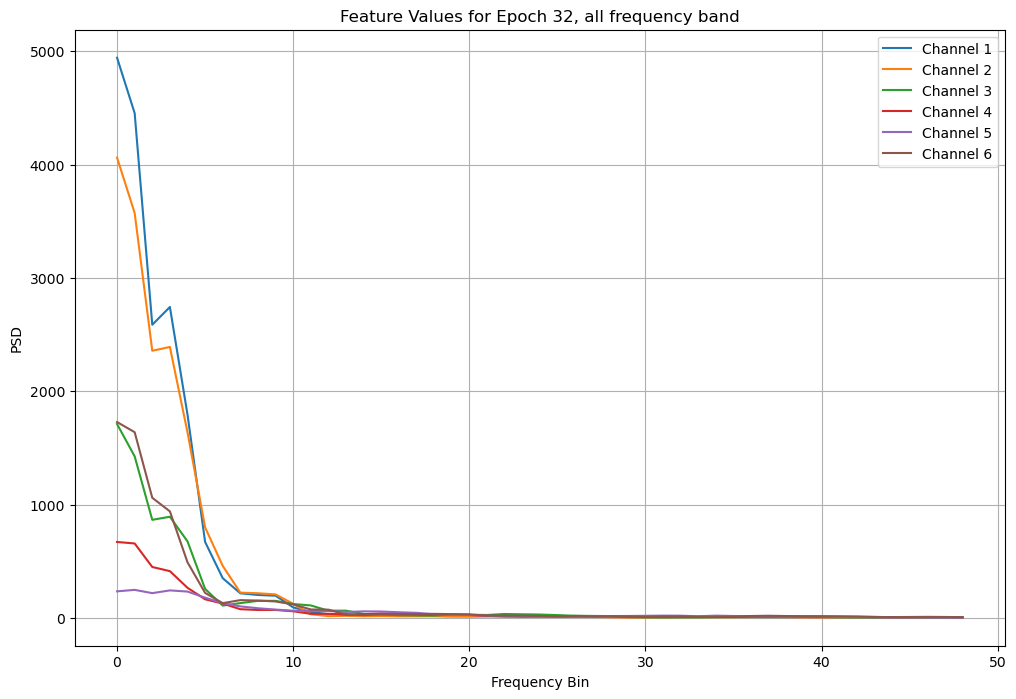

In [5]:
freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (20, 30),
    "gamma": (30, 100),
    "all": (0.5, 100)
}

freq_band = 'all'  # Change this to the specific frequency band you want to visualize

freq_band_key = f'freq_features_{freq_band}_psd_raw'
start_idx, end_idx = feature_idx_map[freq_band_key]
start_idx, end_idx

if feature_handling == "flatten_chs":
    feat_fband = feature_matrix[:, start_idx:end_idx] # (n_epochs, n_channels * n_frequencies)
    feat_band_reshaped = feat_fband.reshape(feat_fband.shape[0], 6, -1) # (n_epochs, n_channels, n_frequencies)
elif feature_handling == "separate_chs":
    feat_band_reshaped = feature_matrix[:, start_idx:end_idx] # (n_epochs, n_channels, n_frequencies)


def plot_feature_values(feat_band_reshaped, freq_band, epoch_idx=31, average_across_epochs=False, average_across_channels=False):
    """
    Plot the feature values for a specific epoch or average across epochs and/or channels.

    Parameters:
    - feat_band_reshaped: numpy.ndarray, reshaped feature matrix (n_epochs, n_channels, n_frequencies)
    - freq_band: str, frequency band name
    - epoch_idx: int, index of the epoch to visualize
    - average_across_epochs: bool, whether to average across epochs
    - average_across_channels: bool, whether to average across channels
    """
    plt.figure(figsize=(12, 8))

    if average_across_epochs:
        # Average the feature values across epochs
        feat_band_reshaped_avg_epochs = np.mean(feat_band_reshaped, axis=0)
        if average_across_channels:
            # Average the feature values across channels
            feature_values_mean = np.mean(feat_band_reshaped_avg_epochs, axis=0)
            feature_values_std = np.std(feat_band_reshaped_avg_epochs, axis=0)
            plt.plot(feature_values_mean, label='Mean Across Channels and Epochs')
            plt.fill_between(range(len(feature_values_mean)), 
                                feature_values_mean - feature_values_std, 
                                feature_values_mean + feature_values_std, 
                                color='b', alpha=0.2, label='STD Across Channels and Epochs')
            plt.title(f'Feature Values for averaged epochs, {freq_band} frequency band, average across channels')
        else:
            # Plot the feature values for all channels
            for channel_idx in range(feat_band_reshaped_avg_epochs.shape[0]):
                feature_values = feat_band_reshaped_avg_epochs[channel_idx, :]
                plt.plot(feature_values, label=f'Channel {channel_idx + 1}')
            plt.title(f'Feature Values for averaged epochs, {freq_band} frequency band')
    else:
        if average_across_channels:
            # Average the feature values across channels
            feature_values_mean = np.mean(feat_band_reshaped[epoch_idx, :, :], axis=0)
            feature_values_std = np.std(feat_band_reshaped[epoch_idx, :, :], axis=0)
            plt.plot(feature_values_mean, label='Mean Across Channels')
            plt.fill_between(range(len(feature_values_mean)), 
                                feature_values_mean - feature_values_std, 
                                feature_values_mean + feature_values_std, 
                                color='b', alpha=0.2, label='STD Across Channels')
            plt.title(f'Feature Values for Epoch {epoch_idx}, {freq_band} frequency band, average across channels')
        else:
            # Plot the feature values for all channels
            for channel_idx in range(feat_band_reshaped.shape[1]):
                feature_values = feat_band_reshaped[epoch_idx, channel_idx, :]
                plt.plot(feature_values, label=f'Channel {channel_idx + 1}')
            plt.title(f'Feature Values for Epoch {epoch_idx}, {freq_band} frequency band')

    plt.xlabel('Frequency Bin')
    plt.ylabel('PSD')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_feature_values(feat_band_reshaped, freq_band, epoch_idx=32, average_across_epochs=False, average_across_channels=False)

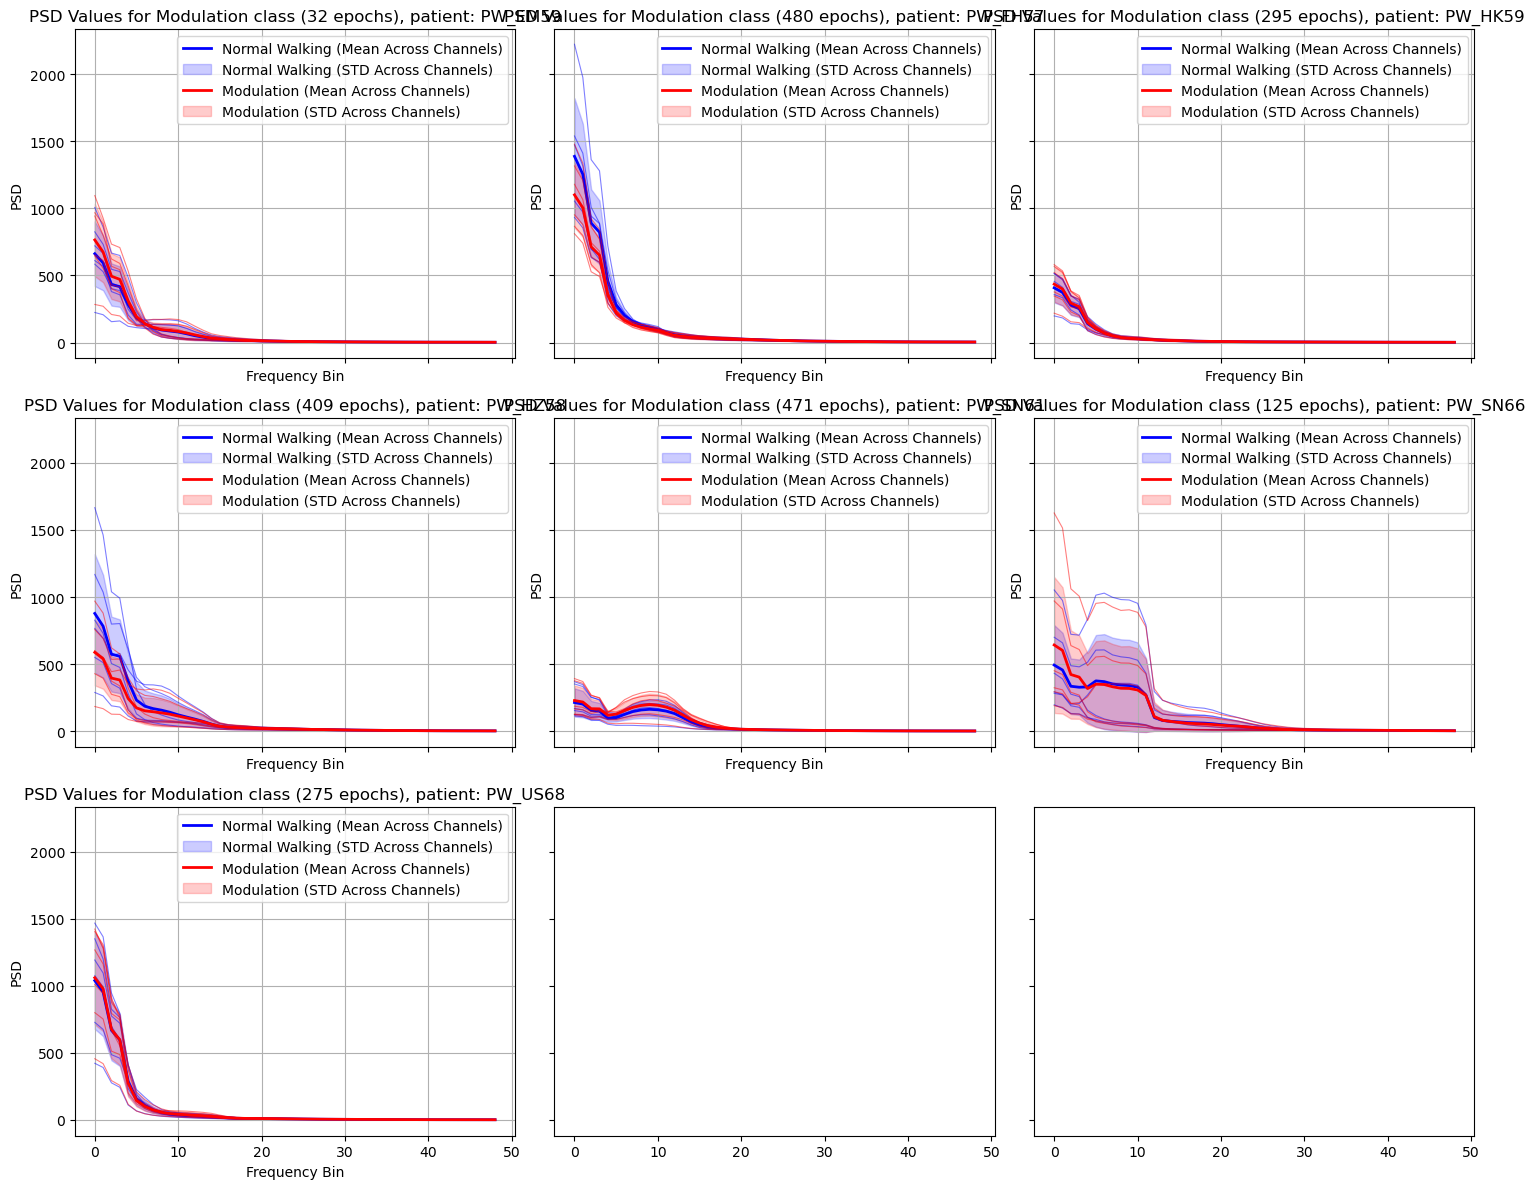

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_patients_feature_values(patients, patient_epochs, feature_extractor, feature_handling="separate_chs", class_labels=['Normal Walking', 'Modulation']):
    """
    Generate a figure that contains plots for each patient.

    Parameters:
    - patients: list, list of patient IDs
    - patient_epochs: dict, dictionary containing epochs data for each patient
    - feature_extractor: FeatureExtractor2, feature extractor object
    - feature_handling: str, feature handling method
    - class_labels: list, class labels to plot
    """
    n_patients = len(patients)
    n_cols = 3
    n_rows = int(np.ceil(n_patients / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharex=True, sharey=True)
    axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

    for i, patient_id in enumerate(patients):
        psds, labels = feature_extractor.extract_features_with_labels(
            patient_epochs[patient_id], feature_handling=feature_handling
        ) # (n_epochs, n_channels, n_frequencies), (n_epochs,) class labels of each epoch

        plot_feature_values_by_class(psds, labels, patient_id=patient_id, 
                                     class_labels=class_labels, 
                                    ax=axs[i])

    plt.tight_layout()
    plt.show()


def plot_feature_values_by_class(psds, labels, patient_id, class_labels=['Normal Walking', 'Modulation'], ax=None):
    """
    Plot the feature values for each class label in separate subplots or in one plot.

    Parameters:
    - psds: numpy.ndarray, reshaped feature matrix (n_epochs, n_channels, n_frequencies)
    - labels: numpy.ndarray, class labels for each epoch
    - class_labels: list, class labels to plot
    - patient_id: str, patient ID
    - ax: matplotlib.axes.Axes, axis to plot on
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    class_label_map = {'Normal Walking': 0, 'Modulation': 1}  # Make sure it matches actual encoding
    colors = ['blue', 'red']  # Define colors for each class

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    for i, label in enumerate(class_labels):
        label_idx = class_label_map[label]
        class_indices = np.where(labels == label_idx)[0]

        if len(class_indices) == 0:
            print(f"Warning: No data for class {label} in patient {patient_id}")
            continue  # Avoid empty plots

        class_feat_band_reshaped = psds[class_indices]

        ax_i = ax
        ax_i.set_title(f'PSD Values for {label} class ({len(class_indices)} epochs), patient: {patient_id}')

        # Average across epochs
        feat_band_reshaped_avg_epochs = np.mean(class_feat_band_reshaped, axis=0)
        feature_values_mean = np.mean(feat_band_reshaped_avg_epochs, axis=0)
        feature_values_std = np.std(feat_band_reshaped_avg_epochs, axis=0)

        for channel_idx in range(feat_band_reshaped_avg_epochs.shape[0]):
            feature_values = feat_band_reshaped_avg_epochs[channel_idx, :]
            ax_i.plot(feature_values, color=colors[i], alpha=0.5, linewidth=0.8)  # Thin line for channels

        ax_i.plot(feature_values_mean, label=f'{label} (Mean Across Channels)', color=colors[i], linewidth=2)  # Thick line for mean
        ax_i.fill_between(range(len(feature_values_mean)), 
                          feature_values_mean - feature_values_std, 
                          feature_values_mean + feature_values_std, 
                          alpha=0.2, label=f'{label} (STD Across Channels)', color=colors[i])

        ax_i.set_xlabel('Frequency Bin')
        ax_i.set_ylabel('PSD')
        ax_i.legend()
        ax_i.grid(True)

    plt.tight_layout()

# Example usage
patients = ['PW_EM59', 'PW_FH57', 'PW_HK59', 'PW_HZ58', 'PW_SN61', 'PW_SN66', 'PW_US68']

plot_all_patients_feature_values(
    patients,
    patient_epochs,
    feature_extractor,
    feature_handling="separate_chs", 
    class_labels=['Normal Walking', 'Modulation'])


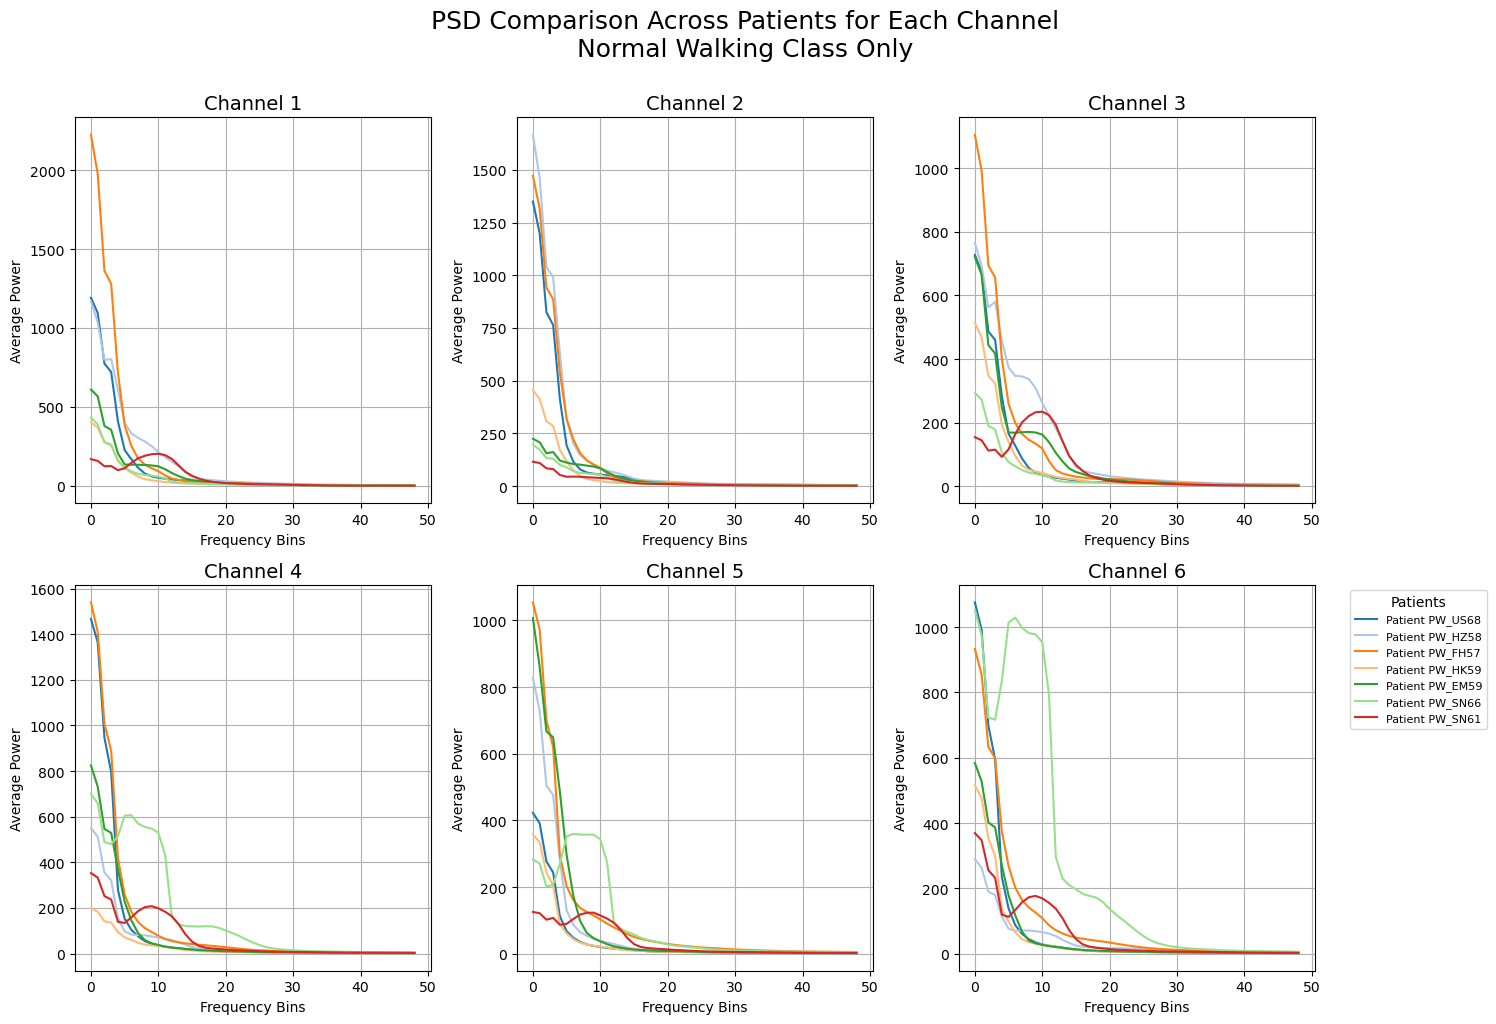

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Define the number of channels and get all patient IDs
n_channels = 6
all_patient_ids = list(patient_epochs.keys())

# Define a color cycle for different patients
colors = cycle(plt.cm.tab20.colors)  # Provides a wide range of distinct colors

# Set up subplots grid for comparing the same channel across patients
plt.figure(figsize=(15, 10))

for ch in range(n_channels):
    ax = plt.subplot(2, 3, ch + 1)  # 2 rows by 3 columns for 6 channels
    
    # Reset color cycle for each channel plot
    color_cycle = cycle(plt.cm.tab20.colors)
    
    for patient_id in all_patient_ids:
        # Extract features and labels for the specified patient
        X_train, y_train = feature_extractor.extract_features_with_labels(
            patient_epochs[patient_id], feature_handling="flatten_chs"
        )

        # Extract PSD feature indices
        psd_feature_keys = [key for key in feature_idx_map.keys() if 'psd_raw' in key]
        psd_feature_indices = {key: feature_idx_map[key] for key in psd_feature_keys}

        # Sort PSD keys to maintain the frequency band order (if available)
        sorted_psd_keys = sorted(psd_feature_indices.keys(), key=lambda x: x.split('_')[-1])

        # Split the data into 'normal_walking' class (label 0) only for comparison
        class_0_mask = (y_train == 0)  # 'normal_walking'

        # Collect PSD values for the specific channel and class
        psd_values_channel = []

        for key in sorted_psd_keys:
            start_idx, end_idx = psd_feature_indices[key]
            
            # Average over samples, split by class
            psd_values_class_0 = np.mean(X_train[class_0_mask, start_idx:end_idx], axis=0)
            
            # Reshape to (channels, frequency_bins) and select the specific channel
            psd_values_reshaped_0 = psd_values_class_0.reshape(n_channels, -1)
            
            # Collect values for the current channel
            psd_values_channel.extend(psd_values_reshaped_0[ch])

        # Plot PSD values with a unique color for each patient
        color = next(color_cycle)
        ax.plot(psd_values_channel, label=f'Patient {patient_id}', color=color, linewidth=1.5)
    
    # Add labels and title to each subplot
    ax.set_title(f'Channel {ch + 1}', fontsize=14)
    ax.set_xlabel('Frequency Bins', fontsize=10)
    ax.set_ylabel('Average Power', fontsize=10)
    ax.grid(True)

# Add a legend to the last subplot only
plt.legend(title='Patients', fontsize=8, loc='upper right', bbox_to_anchor=(1.5, 1))

# Overall figure layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('PSD Comparison Across Patients for Each Channel\nNormal Walking Class Only', fontsize=18, y=1.02)
plt.show()

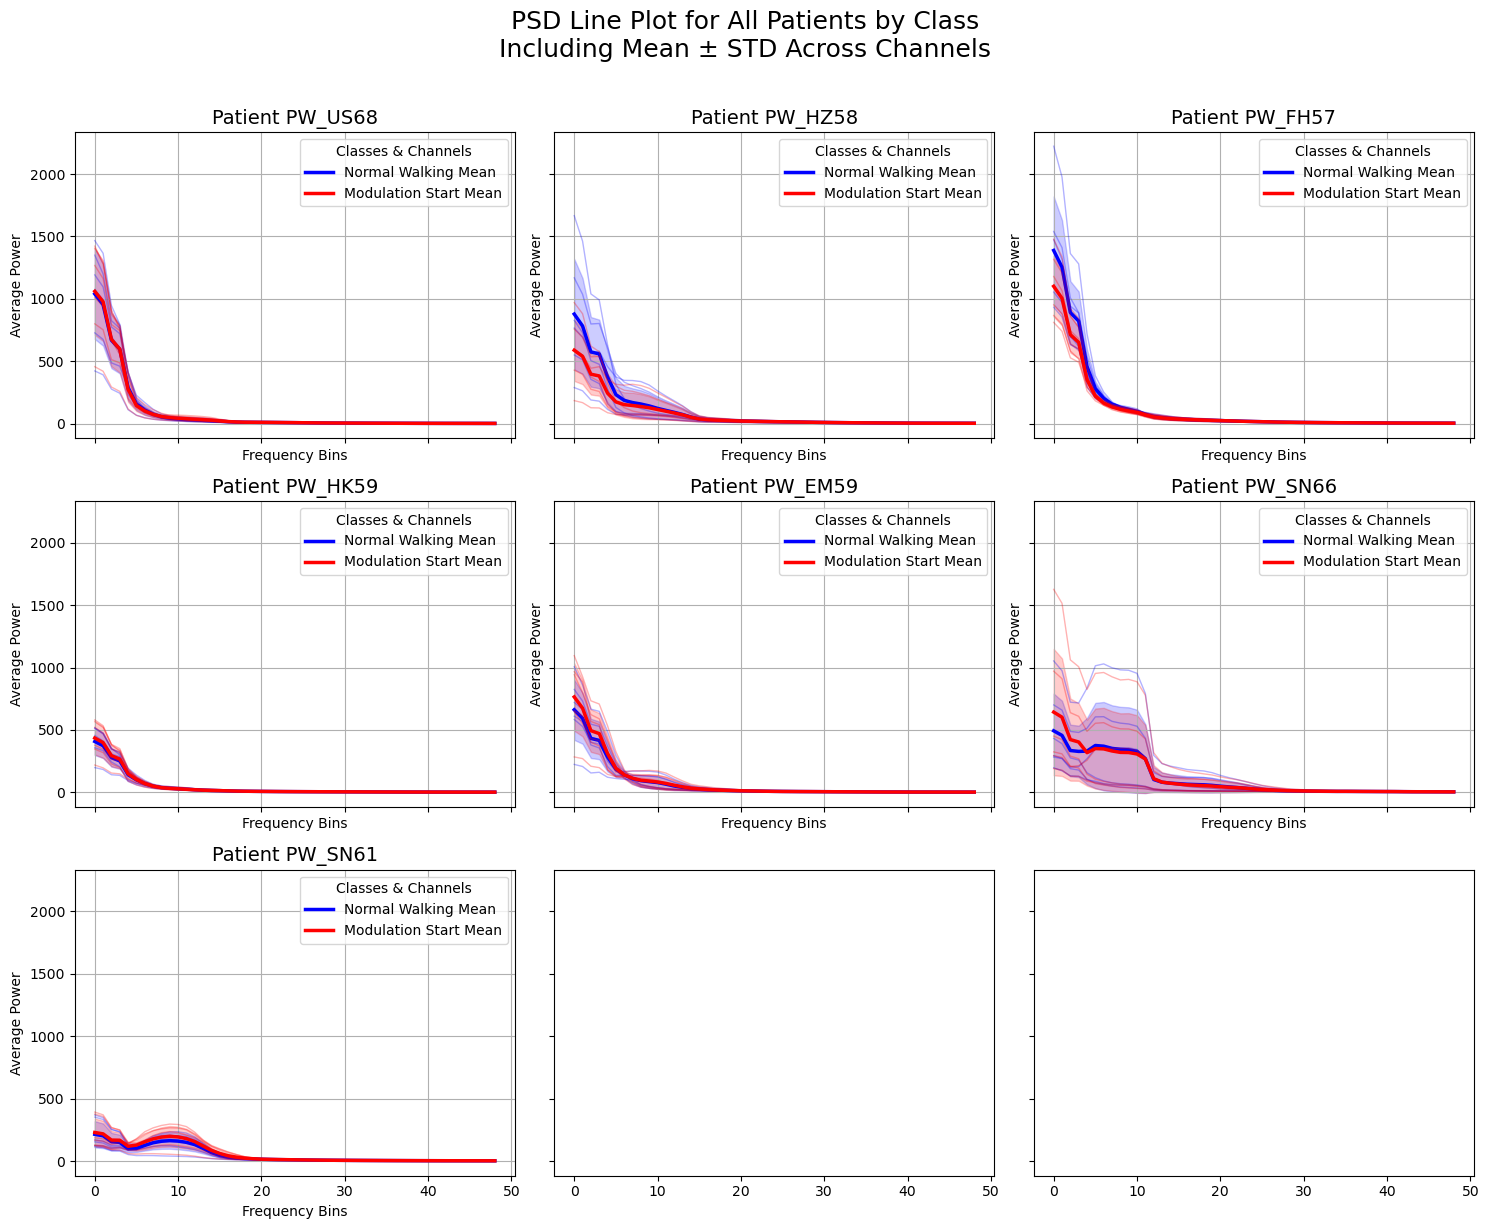

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors and labels for the classes
colors = {0: 'blue', 1: 'red'}
labels = {0: 'Normal Walking', 1: 'Modulation Start'}

# Number of channels
n_channels = 6  

# Get all patient IDs
all_patient_ids = list(patient_epochs.keys())
n_patients = len(all_patient_ids)

# Set up subplots grid (adjust rows and columns based on the number of patients)
n_cols = 3
n_rows = int(np.ceil(n_patients / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharex=True, sharey=True)

for i, patient_id in enumerate(all_patient_ids):
    # Extract features and labels for the specified patient
    X_train, y_train = feature_extractor.extract_features_with_labels(
        patient_epochs[patient_id], feature_handling="flatten_chs"
    )

    # Extract PSD feature indices
    psd_feature_keys = [key for key in feature_idx_map.keys() if 'psd_raw' in key]
    psd_feature_indices = {key: feature_idx_map[key] for key in psd_feature_keys}

    # Sort PSD keys to maintain the frequency band order (if available)
    sorted_psd_keys = sorted(psd_feature_indices.keys(), key=lambda x: x.split('_')[-1])

    # Split the data into classes
    class_0_mask = (y_train == 0)  # 'normal_walking'
    class_1_mask = (y_train == 1)  # 'mod_start'

    # Prepare containers for PSD values per channel and class
    psd_values_per_class = {0: {ch: [] for ch in range(n_channels)}, 
                            1: {ch: [] for ch in range(n_channels)}}

    # Iterate over sorted PSD features and collect values for each channel
    for key in sorted_psd_keys:
        start_idx, end_idx = psd_feature_indices[key]
        
        # Average over samples for smooth line plots, split by class
        psd_values_class_0 = np.mean(X_train[class_0_mask, start_idx:end_idx], axis=0)
        psd_values_class_1 = np.mean(X_train[class_1_mask, start_idx:end_idx], axis=0)
        
        # Reshape to (channels, frequency_bins) and store per channel
        psd_values_reshaped_0 = psd_values_class_0.reshape(n_channels, -1)
        psd_values_reshaped_1 = psd_values_class_1.reshape(n_channels, -1)
        
        # Append the frequency bins to the correct channel for each class
        for ch in range(n_channels):
            psd_values_per_class[0][ch].extend(psd_values_reshaped_0[ch])
            psd_values_per_class[1][ch].extend(psd_values_reshaped_1[ch])

    # Create a subplot for each patient
    ax = axes[i // n_cols, i % n_cols]
    
    # Plot all channels of each class with the same color
    for class_label in [0, 1]:
        for ch in range(n_channels):
            ax.plot(psd_values_per_class[class_label][ch], 
                    color=colors[class_label], 
                    linewidth=1.0, alpha=0.3)

        # Calculate mean and std across channels for each class
        mean_psd = np.mean(list(psd_values_per_class[class_label].values()), axis=0)
        std_psd = np.std(list(psd_values_per_class[class_label].values()), axis=0)

        # Plot mean ± std as bold line with shaded area for each class
        ax.plot(mean_psd, label=f'{labels[class_label]} Mean', color=colors[class_label], linewidth=2.5)
        ax.fill_between(np.arange(len(mean_psd)),
                        mean_psd - std_psd,
                        mean_psd + std_psd,
                        color=colors[class_label], alpha=0.2)
    
    # Add labels and title to each subplot
    ax.set_title(f'Patient {patient_id}', fontsize=14)
    ax.set_xlabel('Frequency Bins', fontsize=10)
    ax.set_ylabel('Average Power', fontsize=10)
    ax.grid(True)
    ax.legend(title='Classes & Channels', fontsize=10, loc='upper right')

# Overall figure layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('PSD Line Plot for All Patients by Class\nIncluding Mean ± STD Across Channels', fontsize=18, y=1.02)
plt.show()


# Feature Viz

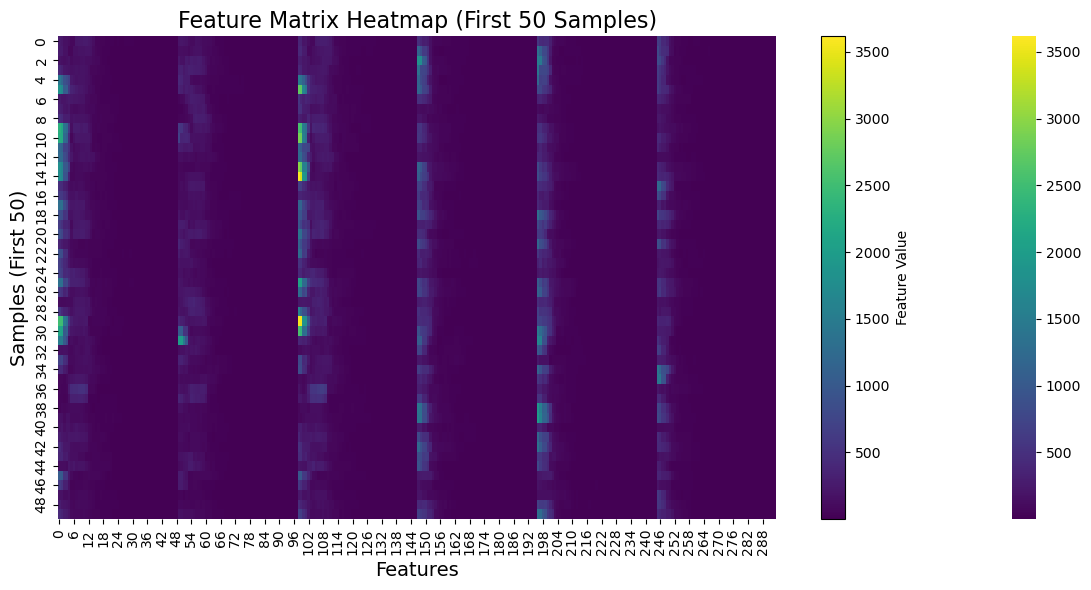

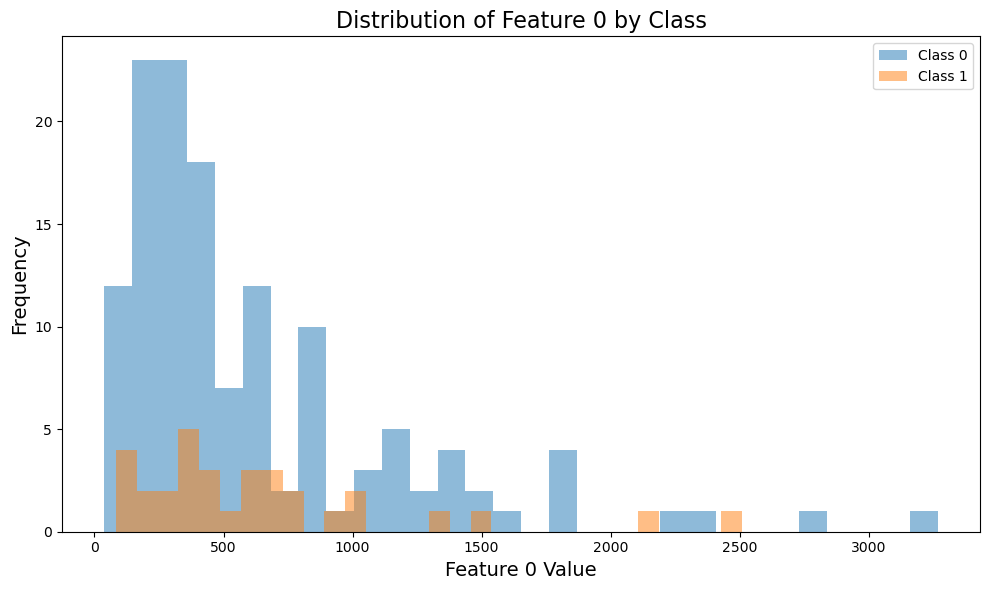

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_94657/2462643098.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


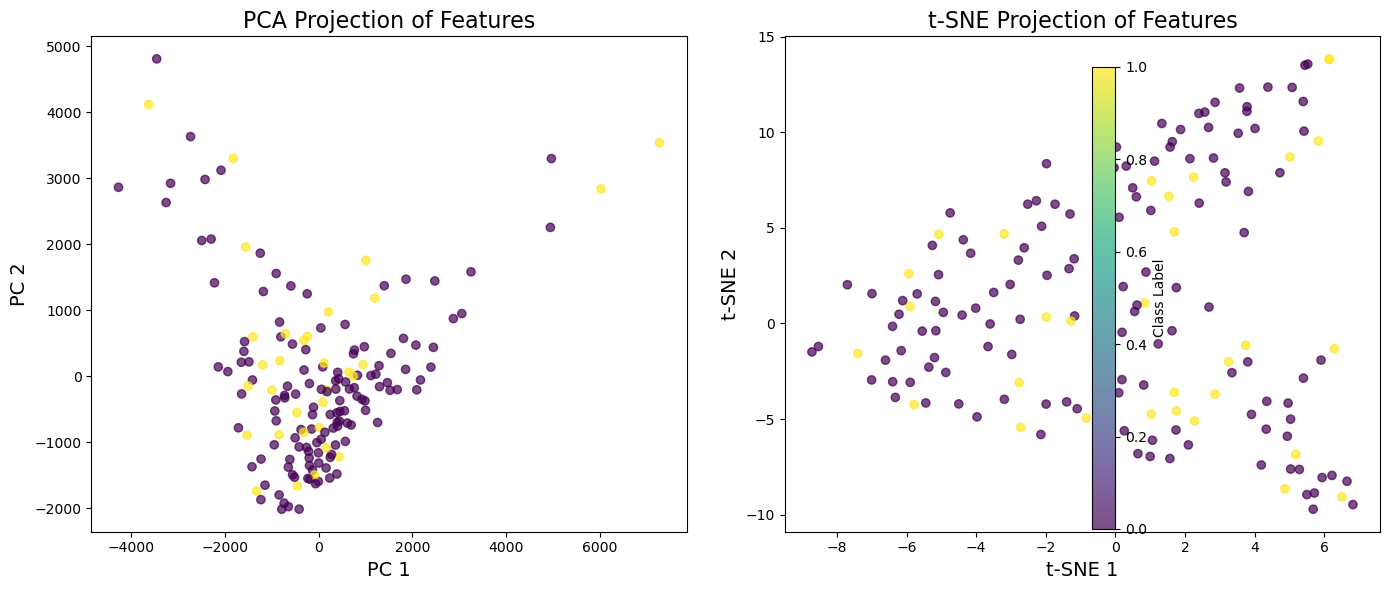

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Example feature matrix and labels (replace with actual data)
X_train, y_train = feature_extractor.extract_features_with_labels(
    patient_epochs['PW_EM59'], feature_handling="flatten_chs"
)

# 1. Heatmap of Feature Matrix
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(X_train[:50, :], cmap='viridis', cbar=True)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Samples (First 50)', fontsize=14)
plt.title('Feature Matrix Heatmap (First 50 Samples)', fontsize=16)
heatmap.figure.colorbar(heatmap.collections[0], label='Feature Value')
plt.gca().set_aspect('auto')  # Optional: set aspect ratio if needed
plt.tight_layout()
plt.show()

# 2. Feature Distributions by Class
plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    plt.hist(X_train[y_train == label, 0], bins=30, alpha=0.5, label=f'Class {label}')
plt.xlabel('Feature 0 Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Feature 0 by Class', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Dimensionality Reduction (PCA + t-SNE)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PCA Visualization
scatter = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
axs[0].set_title('PCA Projection of Features', fontsize=16)
axs[0].set_xlabel('PC 1', fontsize=14)
axs[0].set_ylabel('PC 2', fontsize=14)

# t-SNE Visualization
scatter = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
axs[1].set_title('t-SNE Projection of Features', fontsize=16)
axs[1].set_xlabel('t-SNE 1', fontsize=14)
axs[1].set_ylabel('t-SNE 2', fontsize=14)

plt.colorbar(scatter, ax=axs, label='Class Label')
plt.tight_layout()
plt.show()

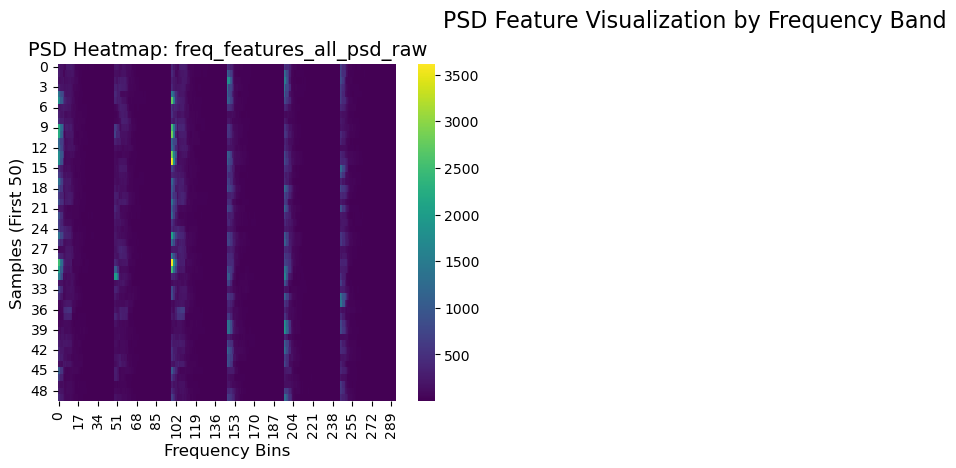

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract PSD feature indices from the feature_idx_map
psd_feature_keys = [key for key in feature_idx_map.keys() if 'psd_raw' in key]
psd_feature_indices = {key: feature_idx_map[key] for key in psd_feature_keys}

# Prepare a figure for visualization
plt.figure(figsize=(14, 8))

# Iterate over PSD feature bands and plot
for i, (band_name, (start_idx, end_idx)) in enumerate(psd_feature_indices.items()):
    plt.subplot(2, 3, i + 1)  # Create subplots in a grid (2 rows, 3 columns)
    psd_values = X_train[:, start_idx:end_idx]
    
    # Heatmap of PSD values
    sns.heatmap(psd_values[:50, :], cmap='viridis', cbar=True)
    plt.title(f'PSD Heatmap: {band_name}', fontsize=14)
    plt.xlabel('Frequency Bins', fontsize=12)
    plt.ylabel('Samples (First 50)', fontsize=12)
    plt.tight_layout()

plt.suptitle('PSD Feature Visualization by Frequency Band', fontsize=16, y=1.02)
plt.show()

# Manual Split of the data


Fold 1
TRAIN patients: ['PW_US68' 'PW_HZ58' 'PW_FH57' 'PW_HK59' 'PW_SN66' 'PW_SN61'], TEST patient: PW_EM59
X_train shape: (5918, 294), y_train shape: (5918,)
X_test shape: (165, 294), y_test shape: (165,)
Class distribution in y_train:
Class 0: 3863 (65.28%) -- (1.53)
Class 1: 2055 (34.72%) -- (2.88)

Class distribution in y_test:
Class 0: 133 (80.61%) -- (1.24)
Class 1: 32 (19.39%) -- (5.16)

Fold 2
TRAIN patients: ['PW_US68' 'PW_HZ58' 'PW_HK59' 'PW_EM59' 'PW_SN66' 'PW_SN61'], TEST patient: PW_FH57
X_train shape: (4776, 294), y_train shape: (4776,)
X_test shape: (1307, 294), y_test shape: (1307,)
Class distribution in y_train:
Class 0: 3169 (66.35%) -- (1.51)
Class 1: 1607 (33.65%) -- (2.97)

Class distribution in y_test:
Class 0: 827 (63.27%) -- (1.58)
Class 1: 480 (36.73%) -- (2.72)

Fold 3
TRAIN patients: ['PW_US68' 'PW_HZ58' 'PW_FH57' 'PW_EM59' 'PW_SN66' 'PW_SN61'], TEST patient: PW_HK59
X_train shape: (5040, 294), y_train shape: (5040,)
X_test shape: (1043, 294), y_test shape: 

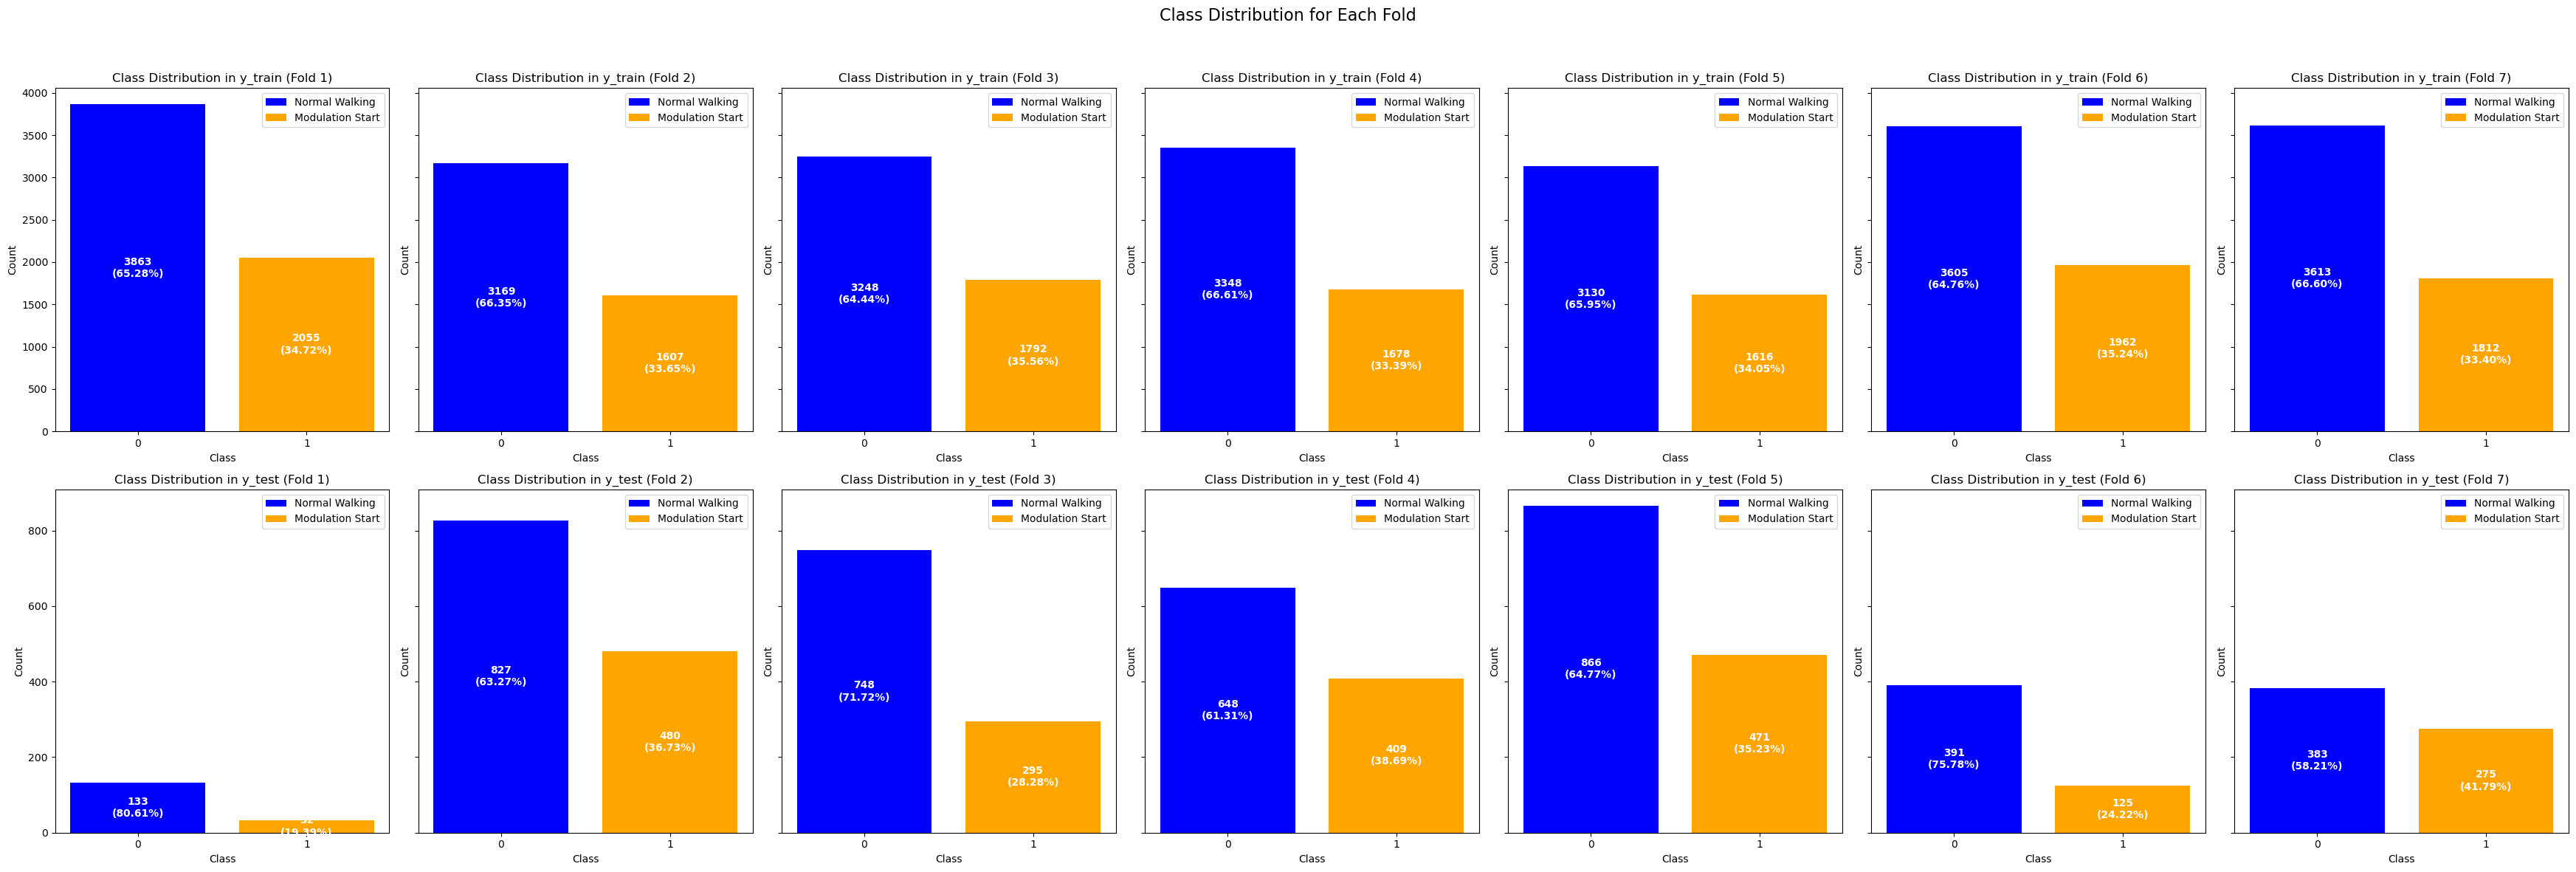

In [11]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

logo = LeaveOneGroupOut()
feature_extractor = FeatureExtractor2(sfreq, features_config)
patient_names = np.array(list(patient_epochs.keys()))

# Create a figure for all subplots with shared y-axis for each row
fig, axes = plt.subplots(2, len(patient_names), figsize=(len(patient_names) * 5, 12), sharey='row')

# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(logo.split(patient_names, groups=patient_names)):
    print(f"\nFold {fold + 1}")
    
    # Split into training and testing sets
    train_patients = patient_names[train_idx]
    test_patient = patient_names[test_idx][0]  # Only one patient in test set
    
    print(f"TRAIN patients: {train_patients}, TEST patient: {test_patient}")
    
    # Feature extraction for the training set
    X_train, y_train = [], []
    for patient in train_patients:
        epochs = patient_epochs[patient]
        X, y = feature_extractor.extract_features_with_labels(epochs, feature_handling="flatten_chs")
        X_train.append(X)
        y_train.append(y)
    
    # Concatenate training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    # Feature extraction for the test set
    X_test, y_test = feature_extractor.extract_features_with_labels(patient_epochs[test_patient])
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    # Count each class label in y_train and y_test
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    # Print the counts
    print("Class distribution in y_train:")
    for label, count in zip(unique_train, counts_train):
        print(f"Class {label}: {count} ({(count / len(y_train) * 100):.2f}%) -- ({(len(y_train)/count):.2f})")

    print("\nClass distribution in y_test:")
    for label, count in zip(unique_test, counts_test):
        print(f"Class {label}: {count} ({(count / len(y_test) * 100):.2f}%) -- ({(len(y_test)/count):.2f})")

    # Training set distribution
    ax_train = axes[0, fold]
    bars_train = ax_train.bar(unique_train, counts_train, color=['blue', 'orange'])
    ax_train.set_title(f'Class Distribution in y_train (Fold {fold + 1})')
    ax_train.set_xlabel('Class')
    ax_train.set_ylabel('Count')
    ax_train.set_xticks(unique_train)
    for i, v in enumerate(counts_train):
        ratio = f"{(v / len(y_train) * 100):.2f}%"
        ax_train.text(i, v / 2, f"{v}\n({ratio})", ha='center', va='center', color='white', fontweight='bold')
    ax_train.legend(bars_train, ['Normal Walking' if label == 0 else 'Modulation Start' for label in unique_train])

    # Test set distribution
    ax_test = axes[1, fold]
    bars_test = ax_test.bar(unique_test, counts_test, color=['blue', 'orange'])
    ax_test.set_title(f'Class Distribution in y_test (Fold {fold + 1})')
    ax_test.set_xlabel('Class')
    ax_test.set_ylabel('Count')
    ax_test.set_xticks(unique_test)
    for i, v in enumerate(counts_test):
        ratio = f"{(v / len(y_test) * 100):.2f}%"
        ax_test.text(i, v / 2, f"{v}\n({ratio})", ha='center', va='center', color='white', fontweight='bold')
    ax_test.legend(bars_test, ['Normal Walking' if label == 0 else 'Modulation Start' for label in unique_test])

plt.suptitle('Class Distribution for Each Fold', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()